# 1. Συλλογή Δεδομένων

In [ ]:
import yfinance as yf

stock = yf.Ticker("GC=F")

hist = stock.history(start="2025-05-12", end="2025-05-17", interval="30m")
hist['Open'].to_csv('msft_open_prices.csv', header=True)

print(hist['Open'].head())

Datetime
2025-05-12 09:30:00-04:00    210.970001
2025-05-12 10:00:00-04:00    208.524994
2025-05-12 10:30:00-04:00    209.169998
2025-05-12 11:00:00-04:00    209.115005
2025-05-12 11:30:00-04:00    208.779999
Name: Open, dtype: float64


# 2. Πολυωνυμική Προσαρμογή

In [183]:
import csv
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


df = pd.read_csv('msft_open_prices.csv')

x = np.arange(len(df))
y = df['Open'].values

# Split the data into training and testing
split_index = int(len(x) * 0.8)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Polynomial degrees to test
degrees = [1, 2, 3]

# Initialize lists to store models, errors, and results
models = []
total_errors = np.zeros(len(degrees))
total_squared_errors = np.zeros(len(degrees))

# Fit polynomial models and calculate errors
for i, degree in enumerate(degrees):
	coeffs = np.polyfit(x_train, y_train, degree)
	poly_func = np.poly1d(coeffs)
	models.append(poly_func)
	
	# Calculate total errors (MAE and MSE)
	for j in range(len(x_test)):
		total_errors[i] += abs(poly_func(x_test[j]) - y_test[j])
		total_squared_errors[i] += (poly_func(x_test[j]) - y_test[j]) ** 2

# Calculate MAE and MSE
MAE = total_errors / len(x_test)
MSE = total_squared_errors / len(x_test)
min_MAE = MAE[0]
best_degree_idx = 0

# Print results
print(f"Data Length: {len(x)}")
print("MAE for each polynomial degree:")
for i, degree in enumerate(degrees):
	print(f"Degree {degree}: {MAE[i]}")
	if MAE[i] < min_MAE:
		best_degree_idx = i
		min_MAE = MAE[i]

print("\nMSE for each polynomial degree:")
for i, degree in enumerate(degrees):
	print(f"Degree {degree}: {MSE[i]}")

print(f"Best fitting model: Degree:{best_degree_idx + 1}, MAE:{min_MAE}")

best_model = models[best_degree_idx]



Data Length: 65
MAE for each polynomial degree:
Degree 1: 1.4270043391113676
Degree 2: 1.8166189437716058
Degree 3: 2.354527274160745

MSE for each polynomial degree:
Degree 1: 2.3971148461840426
Degree 2: 4.458085227407778
Degree 3: 7.2220373659451536
Best fitting model: Degree:1, MAE:1.4270043391113676


## 3. Πρόβλεψη Επόμενης Ημέρας

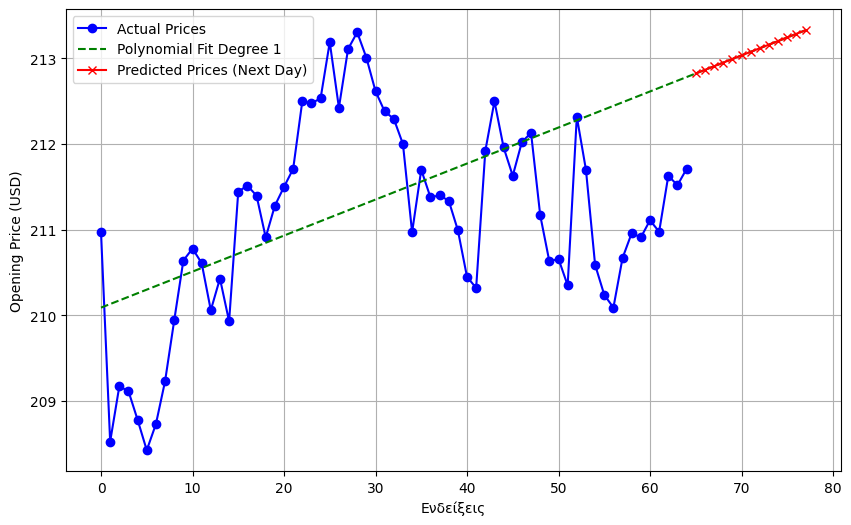

In [184]:
# Create new x values for the next day
new_x = np.arange(len(x), len(x) + 1 * 13)

# Step 3: Use the best polynomial model to predict the 'Open' prices for the next day
predicted_prices = best_model(new_x)

# Δημιουργία γραφήματος
plt.figure(figsize=(10, 6))

# 1. Πραγματικές τιμές (y) ως προς το x
plt.plot(x, y, label="Actual Prices", color='blue', linestyle='-', marker='o')

# 2. Πολυωνυμική καμπύλη προσαρμογής
x_fit = np.linspace(0, len(x) + 1 * 13 - 1, 1000)
y_fit = best_model(x_fit)
plt.plot(x_fit, y_fit, label=f"Polynomial Fit Degree {degrees[best_degree_idx]}", color='green', linestyle='--')

# 3. Προβλέψεις για τις επόμενh ημέρa
plt.plot(new_x, predicted_prices, label="Predicted Prices (Next Day)", color='red', linestyle='-', marker='x')

# Ρυθμίσεις γραφήματος
plt.xlabel('Ενδείξεις')
plt.ylabel('Opening Price (USD)')
plt.legend()
plt.grid(True)

# Εμφάνιση του γραφήματος
plt.show()

## 4. Ολοκλήρωση της Καμπύλης Τιμών για Μέση Τιμή

In [185]:
def trapezoid_rule_area(y, h=1):
	trapezoid_area = 0.0

	for i in range(len(y) - 1):
		trapezoid_area += (y[i] + y[i + 1]) * h / 2

	return trapezoid_area

trapezoid_mean_value = trapezoid_rule_area(y) / (len(y))
print(f"Trapezoid Area: {trapezoid_rule_area(y)}, Mean Value: {trapezoid_mean_value}")

def simpson_rule_area(y):
	simpson_area = y[0] + y[len(y) - 1]
	
	for i in range(1, len(y)-1, 2):
		simpson_area+= 4 * y[i]

	for i in range(2, len(y)-2, 2):
		simpson_area+= 2 * y[i]
	
	simpson_area /= 3
	return simpson_area

simpson_mean_value = simpson_rule_area(y) / (len(y))
print(f"Simpson Area: {simpson_rule_area(y)}, Mean Value: {simpson_mean_value}")

Trapezoid Area: 13513.554832458496, Mean Value: 207.90084357628456
Simpson Area: 13513.466842651367, Mean Value: 207.8994898869441


In [186]:
def trapezoid_rule_func(y, step_count, a, b):
	x_data = np.linspace(a, b, step_count)
	y_data = y(x_data)
	h = (b - a) / (step_count - 1)

	mean = trapezoid_rule_area(y_data, h) / (b - a)
	return mean

print("Linear Model Area:", trapezoid_rule_func(models[0], 1000, 0, len(y)))
print("Quadratic Model Area:", trapezoid_rule_func(models[1], 1000, 0, len(y)))
print("Cubic Model Area:", trapezoid_rule_func(models[2], 1000, 0, len(y)))

print("\nBy step size:")
for i in range(2, 10, 1):
	print(f"Step count: {i} Cubic Model Area: {trapezoid_rule_func(models[2], i, 0, len(y))}")



Linear Model Area: 211.45736692186438
Quadratic Model Area: 210.78376042209547
Cubic Model Area: 210.6667326148284

By step size:
Step count: 2 Cubic Model Area: 207.61595591351607
Step count: 3 Cubic Model Area: 209.90404073216834
Step count: 4 Cubic Model Area: 210.3277601430299
Step count: 5 Cubic Model Area: 210.4760619368314
Step count: 6 Cubic Model Area: 210.54470448139097
Step count: 7 Cubic Model Area: 210.5819917895468
Step count: 8 Cubic Model Area: 210.6044748603272
Step count: 9 Cubic Model Area: 210.61906723799714


In [187]:
def aitken_neville(x, f, pred):
	n = len(x)
	A = [[0] * n for _ in range(n)]

	for i in range(n):
		A[i][0] = f[i]

	for j in range(1, n):
		for i in range(j, n):
			numerator = (x[j - 1] - pred) * A[i][j - 1] - (x[i] - pred) * A[j - 1][j - 1]
			denominator = x[j - 1] - x[i]
			A[i][j] = numerator / denominator
	
	for i in range(0, n):
		for j in range(0, n):
			print(A[i][j], end = " ")
		print()
	return A[n - 1][n - 1]

# Παράδειγμα
x_vals = [2, 4, 6, 8]
y_vals = [1, -2, 3, 5]
pred = aitken_neville(x_vals, y_vals, 5)
print(f"Τελική πρόβλεψη στο x = 3: {pred}")

1 0 0 0 
-2 -3.5 0 0 
3 2.5 -0.5 0 
5 3.0 -1.875 0.1875 
Τελική πρόβλεψη στο x = 3: 0.1875
